In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

pd.set_option('max_columns', 50)

import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, auc
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  PowerTransformer

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

# Exploratory Data Analysis

## Loading and Visualizing data

In [9]:
df = pd.read_csv("/content/drive/MyDrive/Risk Analytics/cs-training.csv")
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


**Variable Name Description Type**

*SeriousDlqin2yrs* Person experienced 90 days past due delinquency or worse Y/N => **target variable**

*RevolvingUtilizationOfUnsecuredLines* Defined as ratio of the total amount of money owed to total credit limit (percentage)

*age* Age of borrower in years (integer)

*NumberOfTime3059DaysPastDueNotWorse* Number of times borrower has been 30-59 days past due but no worse in the last 2 years. (integer)

*DebtRatio* Monthly debt payments, alimony,living costs divided by monthy gross income (percentage)

*MonthlyIncome* Monthly income (real)

*NumberOfOpenCreditLinesAndLoans* Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) (integer)

*NumberOfTimes90DaysLate* Number of times borrower has been 90 days or more past due. (integer)

*NumberRealEstateLoansOrLines* Number of mortgage and real estate loans including home equity lines of credit (integer)

*NumberOfTime60-89DaysPastDueNotWorse* Number of times borrower has been 60-89 days past due but no worse in the last 2 years. (integer)

*NumberOfDependents* Number of dependents in family excluding themselves (spouse, children etc.) (integer)

**Comment:** 
*  11 meaning features, 150k observations: Moderate sized dataset with few features (more long than wide). 
*  Features can be classified into:

  1. Historical late repayments in the last 2 years(3 window periods of 30-59, 60-89, >=90)
  2. Financial Obligations (NumberOfOpenCreditLinesAndLoans, NumberOfDependents, DebtRatio, RevolvingUtilizationOfUnsecuredLines)
  3. Financial Capabilities (MonthlyIncome)
  4. Demographics (Age)

## Checking target variable distribution
Looking at the distribution of the target variable, this problem is a binary classification problem of classes 0 or 1 denoting if cusomter will default in 2 years, with class 1 being the minority at 6.684%

Hence, this is an imbalanced learning problem

Proportion of People Who Defaulted: 0.06684


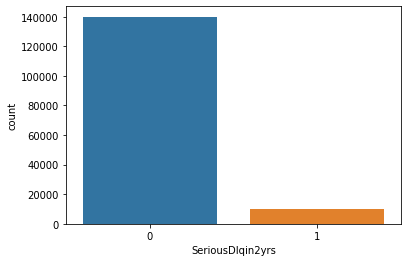

In [ ]:
sns.countplot(x="SeriousDlqin2yrs", data=df)
print("Proportion of People Who Defaulted: {}".format(df["SeriousDlqin2yrs"].sum() / len(df)))

**Comment:** Due to the Bias Nature of the Dataset towards a particular class (0), Precision, Recall, F1-score and AUC are the metrics to evaluate our Predictive Models

## Checking for NAs


In [ ]:
null_val_sums = df.isnull().sum()
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df) })

,Column,Number of Null Values,Proportion
0,Unnamed: 0,0,0.000000
1,SeriousDlqin2yrs,0,0.000000
2,RevolvingUtilizationOfUnsecuredLines,0,0.000000
3,age,0,0.000000
4,NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
5,DebtRatio,0,0.000000
6,MonthlyIncome,29731,0.198207
7,NumberOfOpenCreditLinesAndLoans,0,0.000000
8,NumberOfTimes90DaysLate,0,0.000000
9,NumberRealEstateLoansOrLines,0,0.000000


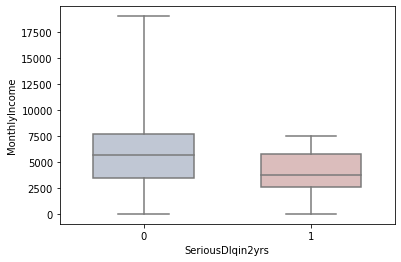

In [ ]:
sns.boxplot(x="SeriousDlqin2yrs", y="MonthlyIncome", data=df.sample(150),
            whis=[0, 100], width=.6, palette="vlag");

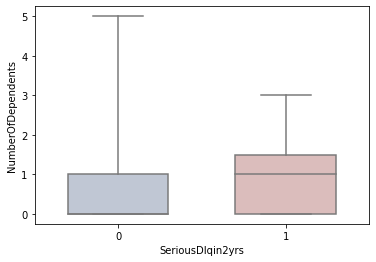

In [ ]:
sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfDependents", data=df.sample(150),
            whis=[0, 100], width=.6, palette="vlag");

**Comment 1:** Only 2 features have nulls (Monthly income and number of dependents). This could be due to customers not wanting to declare these personal information.

**Commenr 2:** We have 29k observations with >= 1 feature having NA values, corresponding to 20% of the dataset, which is quite significant. We will have to impute these NA values rather than dropping observations with NA. Monthly Income and NumberOfDependents have right tail skews, so median imputation is preferred to be robust to outliers.

## Detecting outliers
Many of the financial features have outliers (extreme outliers = > 3xinterquartile range), with a right-tail skew. Hence, we should either use models that are robust to outliers (e.g. tree-based models), or transform the features accordingly (e.g. Box-Cox transformation).

In [ ]:
def get_outlier_counts(df, outlier_threshold=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outlier_counts = ((df < (Q1 - outlier_threshold * IQR)) | (df > (Q3 + outlier_threshold * IQR))).sum()
    return outlier_counts[outlier_counts>0].sort_values(ascending=False)

get_outlier_counts(df, outlier_threshold=3)

DebtRatio                               30457
NumberOfTime30-59DaysPastDueNotWorse    23982
SeriousDlqin2yrs                        10026
NumberOfTimes90DaysLate                  8338
NumberOfTime60-89DaysPastDueNotWorse     7604
MonthlyIncome                            1557
NumberOfDependents                        991
NumberOfOpenCreditLinesAndLoans           442
RevolvingUtilizationOfUnsecuredLines      339
NumberRealEstateLoansOrLines              209
dtype: int64

## Checking for correlations

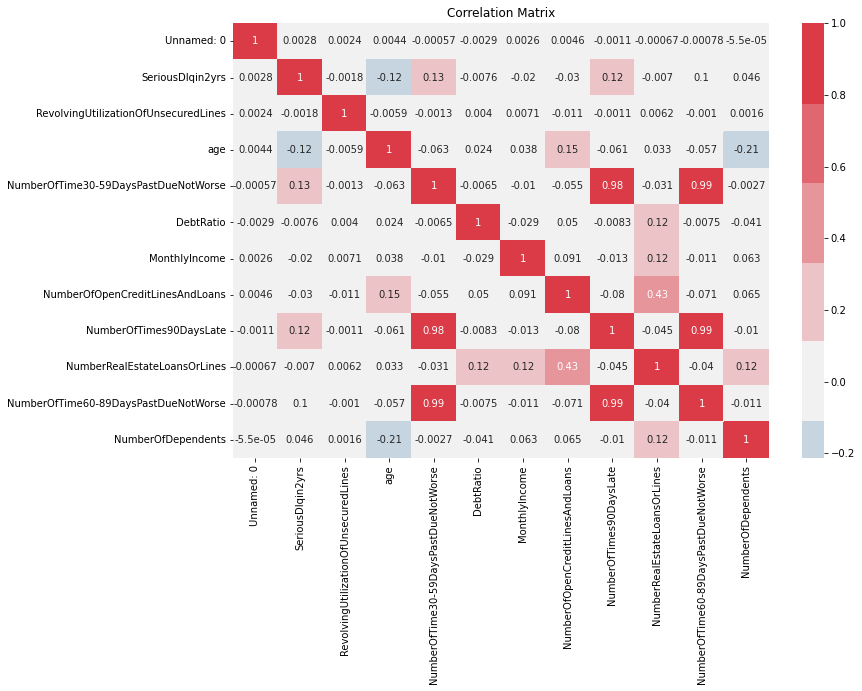

In [ ]:
fig = plt.figure(figsize = [12,8])
sns.heatmap(df.corr(), cmap=sns.diverging_palette(240, 10, n=9),annot=True, center=0)
plt.title("Correlation Matrix", fontsize=12);

**Comment:**
- Detecting multicollinearity: 30, 60 and 90 days past due are highly correlated with each other (close to 1). This may impact performance if the learning algorithm used assumes independence in dependent variables. We can either use models that are robust to multicollinearity (e.g. tree-based models), or use feature selection / regularization methods to use just one of these features.

- 30/60/90 days late payment features have slight positive correlation with the target variable (0.12), while age has slight negative correlation with the target variable (-0.12). These are likely useful features for predicting the target.

=> We consider combine Historical late repayments features to prevent multicollinearity

In [ ]:
#df['Weighted_Sum_PastDue'] = 2 * df['NumberOfTime30-59DaysPastDueNotWorse'] + 3 * df['NumberOfTime60-89DaysPastDueNotWorse'] + 6 * df['NumberOfTimes90DaysLate']

## Handling duplicates
Getting counts of number of rows by the number of duplicates: Most severe = 1 observations with 12 instances. Overall, the training set has not too many duplicates, hence will not likely bias the model much. These duplicates are only a problem if they came from non-random error, e.g. duplicate entry into database. In a real scenario, we should dig deeper to identify if these are errors or coincidences. For this problem, we will not remove these duplicates and assume they are correct.

In [ ]:
df = df.drop(columns = ['Unnamed: 0'])
len(df[df.duplicated()])

609

In [ ]:
df.groupby(df.columns.tolist(),as_index=False).size()['size'].value_counts()

1     120121
2         31
3          7
5          4
4          3
8          1
6          1
12         1
7          1
Name: size, dtype: int64

# Feature Engineering

## Age

Text(0.5, 1.0, 'Train_Dataset')

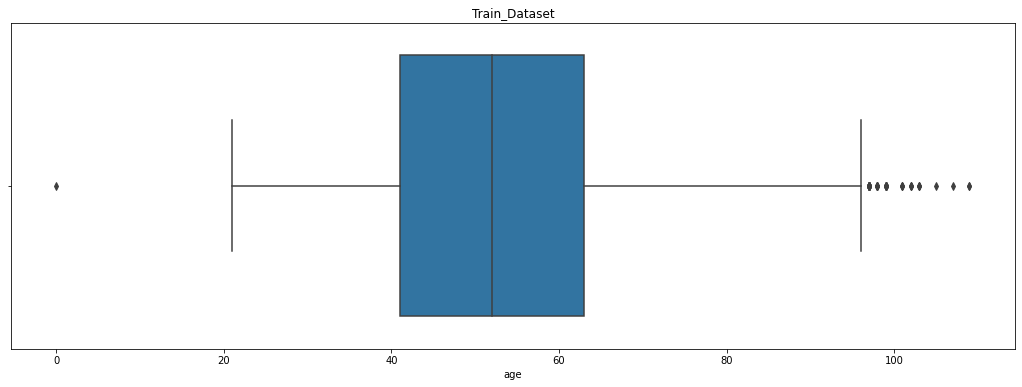

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18,6))
sns.boxplot(x= df['age'])
axes.set_title('Train_Dataset')

In [ ]:
#df['age'].replace(0, 18, inplace=True)

##RevolvingUtilizationOfUnsecuredLines

Text(0.5, 1.0, 'Box Plot of RevolvingUtilizationOfUnsecuredLines')

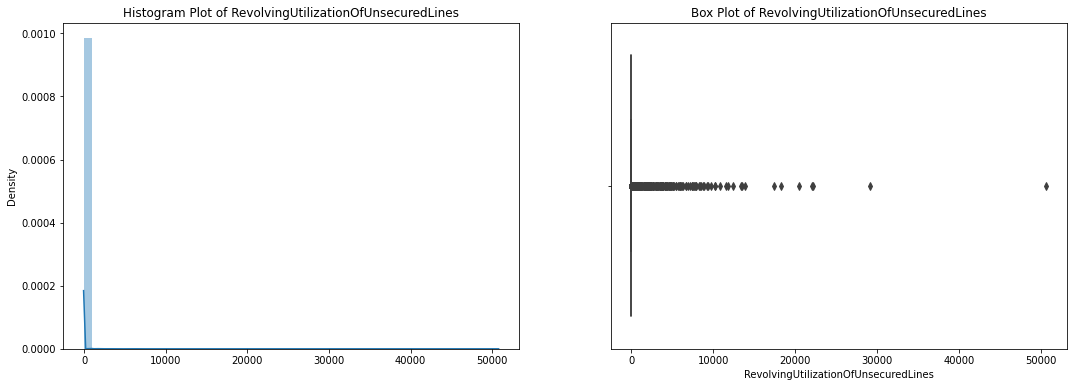

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
sns.distplot(x = np.array(df['RevolvingUtilizationOfUnsecuredLines']),
             ax = axes[0])
axes[0].set_title('Histogram Plot of RevolvingUtilizationOfUnsecuredLines')
sns.boxplot(x = df['RevolvingUtilizationOfUnsecuredLines'], ax = axes[1])
axes[1].set_title('Box Plot of RevolvingUtilizationOfUnsecuredLines')

In [ ]:
df['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [ ]:
df[df['RevolvingUtilizationOfUnsecuredLines'] > df['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)]['RevolvingUtilizationOfUnsecuredLines'].describe()

count     1500.000000
mean       573.887190
std       2432.276153
min          1.093178
25%          1.163345
50%          1.367219
75%          1.991547
max      50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

**Comment:** Not much sense can be made of the plots due to high level of skewness. The summary stats shows that the mean is 40 times bigger than the median and there is huge change in values beyond the 99th percentile value. There are notable extreme outliers.

Text(0.5, 1.0, '2.1% of Train_Dataset')

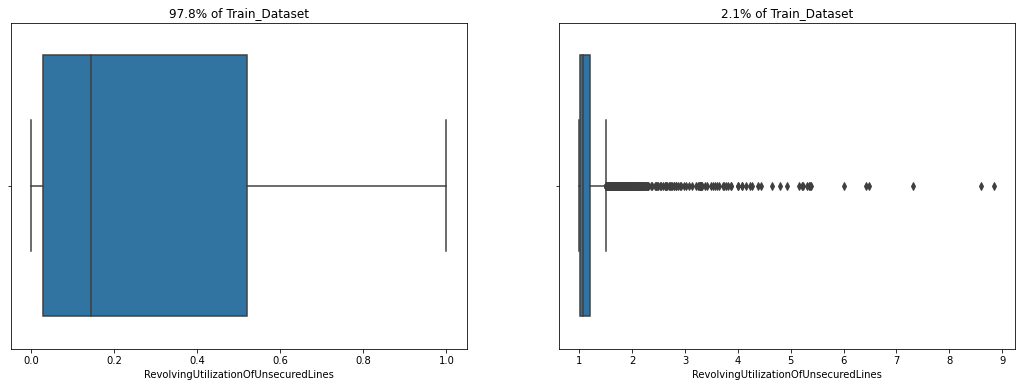

In [ ]:
below_1 = df[df['RevolvingUtilizationOfUnsecuredLines'] < 1]['RevolvingUtilizationOfUnsecuredLines'].count()*100/len(df)
bet_1_10 = df[(df['RevolvingUtilizationOfUnsecuredLines'] > 1) &
        (df['RevolvingUtilizationOfUnsecuredLines'] < 10)]['RevolvingUtilizationOfUnsecuredLines'].count() * 100/len(df)
beyond_10 = df[df['RevolvingUtilizationOfUnsecuredLines'] > 10]['RevolvingUtilizationOfUnsecuredLines'].count()*100/len(df)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(x = df[df['RevolvingUtilizationOfUnsecuredLines'] < 1]['RevolvingUtilizationOfUnsecuredLines'],
            ax = axes[0])
axes[0].set_title('{}% of Train_Dataset'.format(round(below_1, 1)))
sns.boxplot(x = df[(df['RevolvingUtilizationOfUnsecuredLines'] > 1) &
                        (df['RevolvingUtilizationOfUnsecuredLines'] < 10)]['RevolvingUtilizationOfUnsecuredLines'],
            ax = axes[1])
axes[1].set_title('{}% of Train_Dataset'.format(round(bet_1_10, 1)))

**Comment:** Approximately 98% of values of this Variable are between 0 and 1 with a well defined right-skewed distribution. Generally, Credit Utilization is expected to be within this regio (0 - 1). Altough, Borrowers can sometimes spend beyond credit limit. Values between 1 and 10 make up 2% of the dataset. Values beyond 10 are extremely big and they make up less than 0.5% of our data, these values would be dropped to prevent them from impacting our model.

In [ ]:
#df = df.drop(df[df['RevolvingUtilizationOfUnsecuredLines'] > 10].index)

## Debt Ratio

In [ ]:
df.DebtRatio.describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

**Comment:** It is very concerning that someone owes 330,000 times what they own. Maybe that person is a single outlier

In [ ]:
df.DebtRatio.quantile([.975])

0.975    3489.025
Name: DebtRatio, dtype: float64

**Comment:** Apparently 2.5% of the dataset owes more than 3,500 times what they own. We need to investigate further to see if these are outliers or not.

In [ ]:
df[df['DebtRatio'] > 3489.025][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,3750.000000,185.000000
mean,0.064267,0.064865
std,0.245260,0.246956
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [ ]:
df[(df['DebtRatio'] > 3489.025) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome'])].shape[0]

164

**Comment:** We see two particularly concerning things here. 
* The first is that of 3750 records with DebtRatio > 3,500, only 185 of them have a value for monthly income. Further, the people who do have monthly income seem to either have a monthly income of either 1 or 0. 164 of them have the same value for 2 year default rate and monthly income, indicating that there is a data-entry error.
* The second problem is that despite owing thousands of times what they own, these people aren't defaulting any more than the general population. We can conclude that these entries must be data-entry errors, so we will remove them from our model.

In [ ]:
#df = df.drop(df[df['DebtRatio'] > 3489.025].index)

## Late Payment Columns

NumberOfTimes90DaysLate

NumberOfTime60-89DaysPastDueNotWorse

NumberOfTime30-59DaysPastDueNotWorse

In [ ]:
df["NumberOfTimes90DaysLate"].value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [ ]:
df["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [ ]:
df["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [ ]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
distinct_triples_counts = dict()
for arr in df.loc[df["NumberOfTimes90DaysLate"] > 17][late_pay_cols].values:
    triple = ",".join(list(map(str, arr)))
    if triple not in distinct_triples_counts:
        distinct_triples_counts[triple] = 0
    else:
        distinct_triples_counts[triple] += 1
distinct_triples_counts

{'96,96,96': 4, '98,98,98': 263}

**Comment 1:**

There are no one who is 90 or more days past due between 17 and 96 times

There are no one who is 60-89 days past due between 11 and 96 times.

There are no one who is 30-59 days past due between 13 and 96 times.

**Comment 2:**

NumberOfTimes90DaysLate has values above 17, there are 267 instances where the three columns NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse share the same values, specifically 96 and 98.

We can see that sharing the same values of 96 and 98 respectively is not logical since trivial calculations can reveal that being 30 days past due for 96 times for a single person within a timespan of 2 years is not possible.

=>We don't want to throw away this data. We can replace all the 96/98s with 18s to make them not extreme outliers

In [ ]:
# df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] > 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 18
# df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] > 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 18
# df.loc[df['NumberOfTimes90DaysLate'] > 90, 'NumberOfTimes90DaysLate'] = 18

## Monthly Income

In [4]:
df["MonthlyIncome"].describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [5]:
df[df['MonthlyIncome'].isnull()][['NumberOfDependents', 'DebtRatio']].describe()

,NumberOfDependents,DebtRatio
count,25807.000000,29731.000000
mean,0.316310,1673.396556
std,0.809944,4248.372895
min,0.000000,0.000000
25%,0.000000,123.000000
50%,0.000000,1159.000000
75%,0.000000,2382.000000
max,9.000000,329664.000000


In [6]:
df[(df['DebtRatio']>100) & (df['MonthlyIncome'].notnull())]['MonthlyIncome'].describe()

count    1687.000000
mean        0.569650
std         9.812161
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       401.000000
Name: MonthlyIncome, dtype: float64

In [7]:
df[(df['DebtRatio']<=100) & (df['MonthlyIncome'].notnull())]['MonthlyIncome'].describe()

count    1.185820e+05
mean     6.765107e+03
std      1.446446e+04
min      0.000000e+00
25%      3.500000e+03
50%      5.441000e+03
75%      8.300000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

**Comment:** 
Records with missing Monthly Income have high Debt Ratio (Median 1159)

Summary Stat of Borrowers with high Debt Ratio shows that the Monthly Income of these Borrowers are 0

This could mean Borrowers with missing Monthly Income delibrately left the column blank because they are trivial woorkers not earning Monthly Income

The best method to handle this missing values is to replace it with 0

In [ ]:
#df['MonthlyIncome'].replace(np.nan, 0, inplace=True)

## Dependents

In [ ]:
df["NumberOfDependents"].describe()

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [ ]:
df["NumberOfDependents"].value_counts().sort_index()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

In [8]:
df[df['NumberOfDependents'].isnull()][['MonthlyIncome', 'DebtRatio']].describe()

,MonthlyIncome,DebtRatio
count,0.0,3924.000000
mean,NaN,1083.812181
std,NaN,4186.731843
min,NaN,0.000000
25%,NaN,21.000000
50%,NaN,358.000000
75%,NaN,1559.000000
max,NaN,220516.000000


**Comment:**

Records with missing Number of Dependents occured simultaneously with missing missing MonthlyIncome (i.e they share the same index)

This shows that same set of borrowers that left their Monthly Income blank also left Number of Dependents field Blank.

Summary stat of Borrowers with missing monthly Income reveals they have no dependents

It's quite logical that this category of borrowers with little to no Income have no dependents.

Thus, the best way to handle this missing values is to replace with 0

In [ ]:
#df['NumberOfDependents'].replace(np.nan, 0,inplace = True)

## Number of open credit line

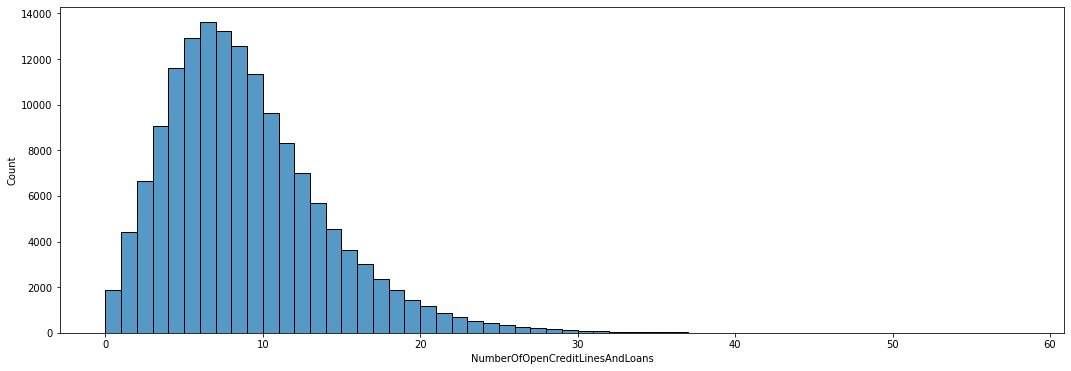

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18,6))
sns.histplot(x = df['NumberOfOpenCreditLinesAndLoans'], binwidth=1)

**Comment:** 
This variable is right-skewed with no extreme values. Further preprocessing of this data would be aggregating similar Category (Fine Class) to a Coarse class during WOE Feature Engineering and Data Preprocessing.

## Number of real estate loans and lines

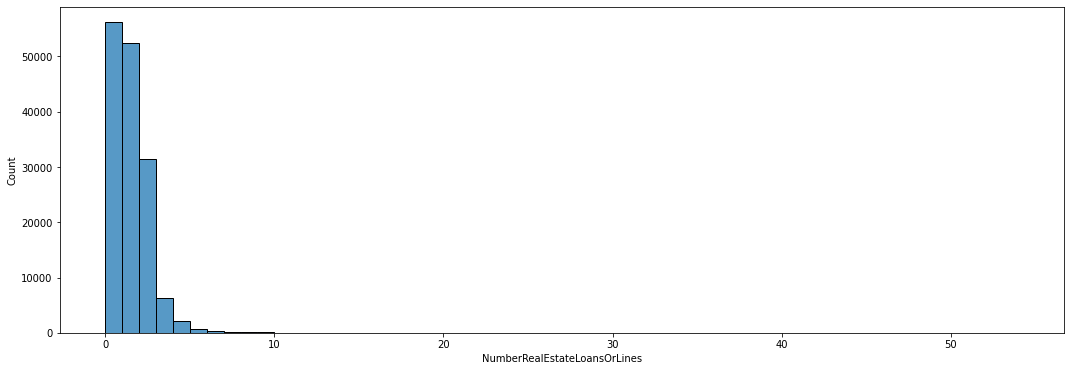

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(18,6))
sns.histplot(x = df['NumberRealEstateLoansOrLines'], binwidth=1)

In [ ]:
df['NumberRealEstateLoansOrLines'].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
15        7
14        7
17        4
16        4
25        3
18        2
23        2
19        2
20        2
26        1
54        1
21        1
29        1
32        1
Name: NumberRealEstateLoansOrLines, dtype: int64

**Comment**
This variable is highly skewed to the right, Majority of the Borrowers have between 0 to 2 Mortgage loans. Further preprocessing of this data would be aggregating similar Category (Fine Class) to a Coarse class during WOE Feature Engineering and Data Preprocessing.

## Overall: 
Based on EDA, we have found the need:

*  scaling (Box-Cox via PowerTransformer)
*  droping RevolvingUtilizationOfUnsecuredLines >10 and DebtRatio > 3489.025
*  imputing MonthlyIncome and NumberofDependent with median
*  replace Late Payment Columns > 90 by 18
*  add new feature = sum of Late Payment to prevent multicollinearity (but it give bad predict result) => keep original feature 


In [ ]:
df

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [10]:
df = df.drop(columns = ['Unnamed: 0'])

to_drop_train = df[df['RevolvingUtilizationOfUnsecuredLines'] > 10].index.values
df.drop(to_drop_train, axis = 0, inplace = True)

df = df.drop(df[df['DebtRatio'] > 3489.025].index)
df['MonthlyIncome'].replace(np.nan, 0, inplace=True)
df['NumberOfDependents'].replace(np.nan, 0,inplace = True)
df['age'].replace(0, 18, inplace=True)

df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] > 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 18
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] > 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 18
df.loc[df['NumberOfTimes90DaysLate'] > 90, 'NumberOfTimes90DaysLate'] = 18

# df['Weighted_Sum_PastDue'] = 2 * df['NumberOfTime30-59DaysPastDueNotWorse'] + 3 * df['NumberOfTime60-89DaysPastDueNotWorse'] + 6 * df['NumberOfTimes90DaysLate']
# df = df.drop(columns = ['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate'])

df_train_inputs = df.loc[:, df.columns.values[1:]]
df_train_target = df.loc[:, df.columns.values[0]].to_frame()

#stratified split
X_train, X_valid, y_train, y_valid = train_test_split(np.array(df_train_inputs), np.array(df_train_target),
                                                      test_size = 0.2, random_state = 42, stratify = np.array(df_train_target))
  
scaler = PowerTransformer().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [11]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [12]:
df2 = df.copy()

In [13]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(116816, 10)
(29205, 10)
(116816, 1)
(29205, 1)


# Logistic Regression

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27251
           1       0.54      0.17      0.26      1954

    accuracy                           0.93     29205
   macro avg       0.74      0.58      0.61     29205
weighted avg       0.92      0.93      0.92     29205



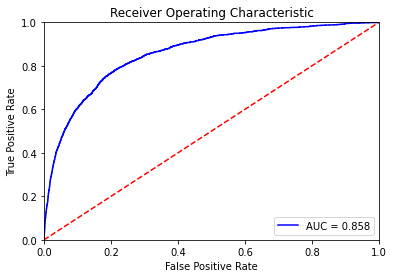

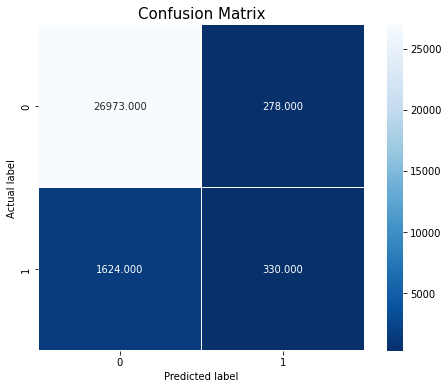

0.8577341137453492

In [14]:
# ROC curve function
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
def plot_roc(y_valid, y_pred_proba):
    fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

def logistic(X_train, y_train, X_valid, y_valid):

  #logistic regression object
  lr = LogisticRegression(max_iter=300, solver = 'liblinear')

  #fit logistic regression
  lr.fit(X_train, y_train)

  #predictions 1 or 0
  y_pred = lr.predict(X_valid)

  #predictions in probalities
  y_pred_proba = lr.predict_proba(X_valid)
  y_pred_proba = y_pred_proba[: ][: , 1]

  #classification report: recall, precision, f1-score, accuracy
  print(classification_report(y_valid, y_pred))

  #ROC_curve
  plot_roc(y_valid, y_pred_proba)

  #confusion matrix
  cm = metrics.confusion_matrix(y_valid, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square =True, cmap = 'Blues_r');
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  all_sample_title = 'Confusion Matrix'
  plt.title(all_sample_title, size = 15)
  plt.show()

  score = roc_auc_score(y_valid, y_pred_proba)
  return score

logistic(X_train, y_train, X_valid, y_valid)

# WOE

In [15]:
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_bad']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_bad'] = df['prop_bad'] * df['n_obs']
    df['n_good'] = (1 - df['prop_bad']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = (1 - df['prop_bad']).diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    #df['IV'] = df['IV'].replace([np.inf, -np.inf], np.nan).sum()
    return df

def woe_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_bad']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_bad'] = df['prop_bad'] * df['n_obs']
    df['n_good'] = (1 - df['prop_bad']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = (1 - df['prop_bad']).diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    #df['IV'] = df['IV'].replace([np.inf, -np.inf], np.nan).sum()
    return df
    
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

## Discovering categorical feature in WOE

### NUMBER OF DAYS PAST DUE 30-59

In [ ]:
df_temp = woe_discrete(df_train_inputs, 'NumberOfTime30-59DaysPastDueNotWorse', df_train_target);
df_temp

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NumberOfTime30-59DaysPastDueNotWorse,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
11,11,1,1.000000,0.000007,1.0,0.0,0.000000,0.000102,-inf,NaN,NaN,inf
13,13,1,1.000000,0.000007,1.0,0.0,0.000000,0.000102,-inf,0.000000,NaN,inf
10,10,3,0.666667,0.000021,2.0,1.0,0.000007,0.000205,-3.328439,0.333333,inf,0.000657
14,18,269,0.546468,0.001842,147.0,122.0,0.000895,0.015048,-2.821704,0.120198,0.506736,0.039933
6,6,137,0.525547,0.000938,72.0,65.0,0.000477,0.007370,-2.737571,0.020921,0.084133,0.018871
7,7,52,0.519231,0.000356,27.0,25.0,0.000183,0.002764,-2.712253,0.006317,0.025318,0.006999
12,12,2,0.500000,0.000014,1.0,1.0,0.000007,0.000102,-2.635292,0.019231,0.076961,0.000250
5,5,324,0.453704,0.002219,147.0,177.0,0.001299,0.015048,-2.449575,0.046296,0.185717,0.033678
4,4,715,0.433566,0.004897,310.0,405.0,0.002972,0.031733,-2.367977,0.020137,0.081598,0.068104
3,3,1691,0.353637,0.011581,598.0,1093.0,0.008022,0.061214,-2.032201,0.079930,0.335776,0.108097


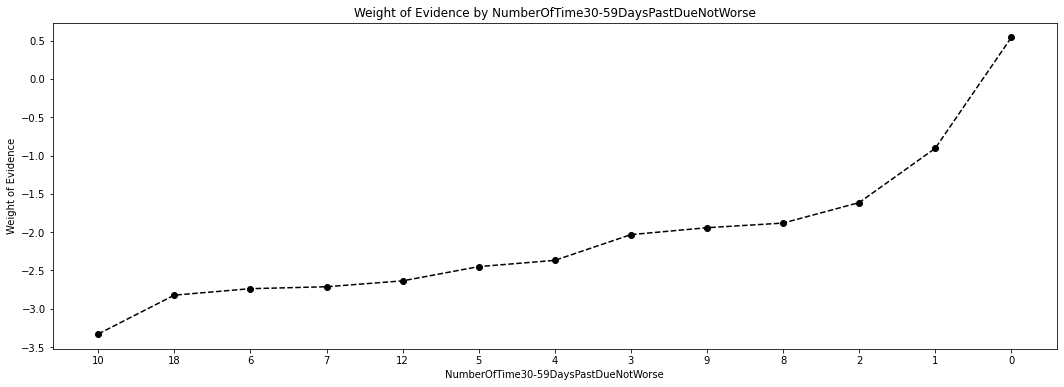

In [ ]:
plot_by_woe(df_temp)

### NUMBER OF DAYS PAST DUE 60 - 89

In [ ]:
df_temp = woe_discrete(df_train_inputs, 'NumberOfTime60-89DaysPastDueNotWorse', df_train_target)
df_temp

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NumberOfTime60-89DaysPastDueNotWorse,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
10,11,1,1.000000,0.000007,1.0,0.0,0.000000,0.000102,-inf,NaN,NaN,inf
6,6,16,0.750000,0.000110,12.0,4.0,0.000029,0.001228,-3.733904,0.250000,inf,0.004477
5,5,33,0.636364,0.000226,21.0,12.0,0.000088,0.002150,-3.194908,0.113636,0.538997,0.006587
4,4,100,0.620000,0.000685,62.0,38.0,0.000279,0.006347,-3.124840,0.016364,0.070068,0.018961
3,3,315,0.561905,0.002157,177.0,138.0,0.001013,0.018119,-2.884188,0.058095,0.240652,0.049336
11,18,269,0.546468,0.001842,147.0,122.0,0.000895,0.015048,-2.821704,0.015436,0.062485,0.039933
2,2,1090,0.500917,0.007465,546.0,544.0,0.003993,0.055891,-2.638962,0.045551,0.182742,0.136958
7,7,8,0.500000,0.000055,4.0,4.0,0.000029,0.000409,-2.635292,0.000917,0.003670,0.001002
8,8,2,0.500000,0.000014,1.0,1.0,0.000007,0.000102,-2.635292,0.000000,0.000000,0.000250
1,1,5604,0.309957,0.038378,1737.0,3867.0,0.028381,0.177807,-1.834972,0.190043,0.800320,0.274193


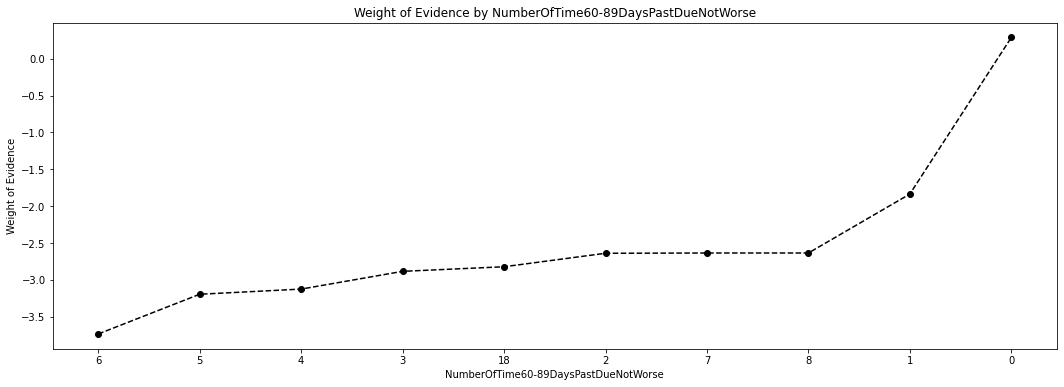

In [ ]:
plot_by_woe(df_temp)

### NUMBER OF DAYS PAST DUE 90

In [ ]:
df_temp = woe_discrete(df_train_inputs, 'NumberOfTimes90DaysLate', df_train_target)
df_temp

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NumberOfTimes90DaysLate,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
16,17,1,1.000000,0.000007,1.0,0.0,0.000000,0.000102,-inf,NaN,NaN,inf
7,7,37,0.810811,0.000253,30.0,7.0,0.000051,0.003071,-4.090579,0.189189,inf,0.012352
9,9,19,0.736842,0.000130,14.0,5.0,0.000037,0.001433,-3.664911,0.073969,0.425668,0.005118
8,8,20,0.700000,0.000137,14.0,6.0,0.000044,0.001433,-3.482590,0.036842,0.182322,0.004838
4,4,287,0.668990,0.001965,192.0,95.0,0.000697,0.019654,-3.338910,0.031010,0.143679,0.063295
5,5,129,0.627907,0.000883,81.0,48.0,0.000352,0.008292,-3.158540,0.041083,0.180370,0.025076
10,10,8,0.625000,0.000055,5.0,3.0,0.000022,0.000512,-3.146118,0.002907,0.012423,0.001541
6,6,78,0.589744,0.000534,46.0,32.0,0.000235,0.004709,-2.998197,0.035256,0.147920,0.013414
3,3,656,0.574695,0.004493,377.0,279.0,0.002048,0.038591,-2.936325,0.015048,0.061872,0.107304
17,18,269,0.546468,0.001842,147.0,122.0,0.000895,0.015048,-2.821704,0.028227,0.114622,0.039933


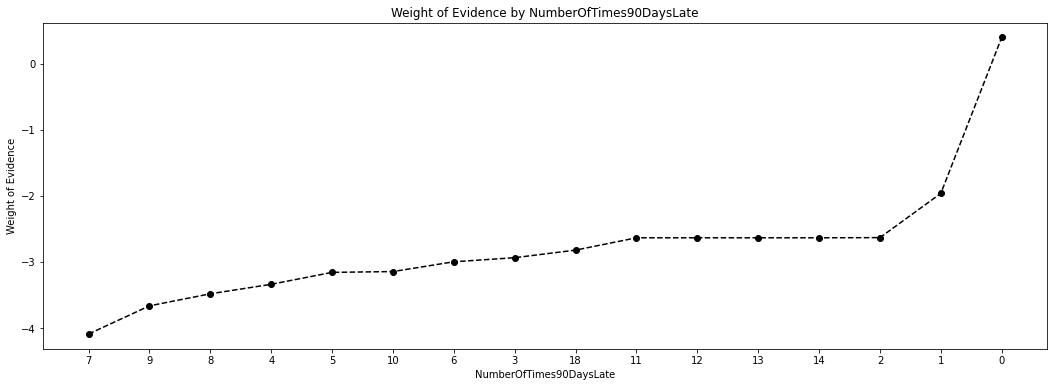

In [ ]:
plot_by_woe(df_temp)

### NUMBER OF DEPENDENTS

In [ ]:
df_temp = woe_discrete(df_train_inputs, 'NumberOfDependents', df_train_target)
df_temp

,NumberOfDependents,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
6,6.0,156,0.153846,0.001068,24.0,132.0,0.000969,0.002457,-0.930544,NaN,NaN,0.001385
4,4.0,2807,0.104738,0.019223,294.0,2513.0,0.018444,0.030095,-0.489639,0.049108,0.440905,0.005705
7,7.0,51,0.098039,0.000349,5.0,46.0,0.000338,0.000512,-0.416089,0.006699,0.073551,0.000072
5,5.0,734,0.091281,0.005027,67.0,667.0,0.004895,0.006858,-0.337195,0.006759,0.078894,0.000662
3,3.0,9271,0.089311,0.063491,828.0,8443.0,0.061966,0.084758,-0.313212,0.001970,0.023982,0.007139
8,8.0,24,0.083333,0.000164,2.0,22.0,0.000161,0.000205,-0.237397,0.005977,0.075815,0.000010
2,2.0,19117,0.081237,0.130920,1553.0,17564.0,0.128908,0.158972,-0.209629,0.002097,0.027768,0.006302
1,1.0,25937,0.073486,0.177625,1906.0,24031.0,0.176372,0.195107,-0.100954,0.007751,0.108675,0.001891
0,0.0,87914,0.057897,0.602064,5090.0,82824.0,0.607874,0.521036,0.154148,0.015588,0.255102,0.013386
9,9.0,4,0.000000,0.000027,0.0,4.0,0.000029,0.000000,inf,0.057897,inf,inf


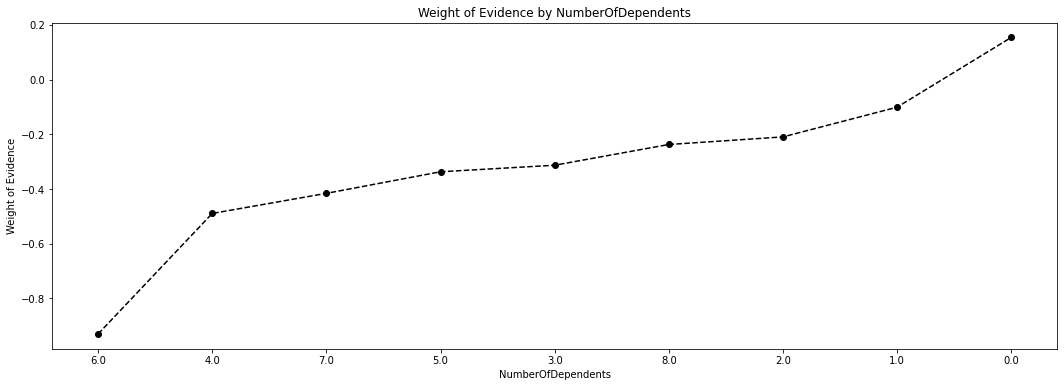

In [ ]:
plot_by_woe(df_temp)

## Combining

In [16]:
def WOE(df_train):
  df_train_inputs = df_train

  #NumberOfTime30-59DaysPastDueNotWorse
  df_train_inputs['PastDue30-59:11-13-18-10'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([11,13,96,10]), 1, 0)
  df_train_inputs['PastDue30-59:6-7-12'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([98,6,7,12]), 1, 0)
  df_train_inputs['PastDue30-59:5-4'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([5,4]), 1, 0)
  df_train_inputs['PastDue30-59:3'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([3]), 1, 0)
  df_train_inputs['PastDue30-59:9-8'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([9,8]), 1, 0)
  df_train_inputs['PastDue30-59:2'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([2]), 1, 0)
  df_train_inputs['PastDue30-59:1'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([1]), 1, 0)
  #df_train_inputs['PastDue30-59:0'] = np.where(df_train_inputs['NumberOfTime30-59DaysPastDueNotWorse'].isin([1]), 1, 0)

  #NumberOfTime60-89DaysPastDueNotWorse
  df_train_inputs['PastDue60-89:11-6-9'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([11,96,6,9]), 1, 0)
  df_train_inputs['PastDue60-89:4-5'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([4,5]), 1, 0)
  df_train_inputs['PastDue60-89:3-18'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([3, 98]), 1, 0)
  df_train_inputs['PastDue60-89:7-8'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([7, 8]), 1, 0)
  df_train_inputs['PastDue60-89:2'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([2]), 1, 0)
  df_train_inputs['PastDue60-89:1'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([1]), 1, 0)
  #df_train_inputs['PastDue60-89:0'] = np.where(df_train_inputs['NumberOfTime60-89DaysPastDueNotWorse'].isin([0]), 1, 0)

  #PastDue90
  df_train_inputs['PastDue90:9-7-17-15-8'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([9,96,7,17,15,8]), 1, 0)
  df_train_inputs['PastDue90:4-5'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([4,5]), 1, 0)
  df_train_inputs['PastDue90:6-10-11'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([6,10,11]), 1, 0)
  df_train_inputs['PastDue90:3-18'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([3,98]), 1, 0)
  df_train_inputs['PastDue90:12-13-14'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([12,13,14]), 1, 0)
  df_train_inputs['PastDue90:2'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([2]), 1, 0)
  df_train_inputs['PastDue90:1'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([1]), 1, 0)
  #df_train_inputs['PastDue90:0'] = np.where(df_train_inputs['NumberOfTimes90DaysLate'].isin([0]), 1, 0)

  #NumberOfDependents
  df_train_inputs['NumberOfDependents:>9'] = np.where(df_train_inputs['NumberOfDependents'].isin([9,10,13,20]), 1, 0)
  df_train_inputs['NumberOfDependents:6'] = np.where(df_train_inputs['NumberOfDependents'].isin([6]), 1, 0)
  df_train_inputs['NumberOfDependents:4'] = np.where(df_train_inputs['NumberOfDependents'].isin([4]), 1, 0)
  df_train_inputs['NumberOfDependents:1'] = np.where(df_train_inputs['NumberOfDependents'].isin([1]), 1, 0)
  df_train_inputs['NumberOfDependents:2'] = np.where(df_train_inputs['NumberOfDependents'].isin([2]), 1, 0)
  df_train_inputs['NumberOfDependents:7'] = np.where(df_train_inputs['NumberOfDependents'].isin([7]), 1, 0)
  df_train_inputs['NumberOfDependents:5'] = np.where(df_train_inputs['NumberOfDependents'].isin([5]), 1, 0)
  df_train_inputs['NumberOfDependents:3'] = np.where(df_train_inputs['NumberOfDependents'].isin([3]), 1, 0)
  df_train_inputs['NumberOfDependents:8'] = np.where(df_train_inputs['NumberOfDependents'].isin([8]), 1, 0)
  #df_train_inputs['NumberOfDependents:0'] = np.where(df_train_inputs['NumberOfDependents'].isin([0]), 1, 0)
  
  #Monthly Income
  bins = pd.IntervalIndex.from_tuples([(0, 1000)])
  bins3 = pd.IntervalIndex.from_tuples([(10000, 12000), (12000, 14000), (14000, 16000), (16000, 20000)])
  bins4 = pd.IntervalIndex.from_tuples([(20000, 30000), (30000, 50000)])
  box1 = pd.cut(df_train[df_train['MonthlyIncome'] <= 1000]['MonthlyIncome'], bins).cat.codes
  box2 = pd.qcut(df_train[(df_train['MonthlyIncome'] > 1000) & 
                          (df_train['MonthlyIncome'] <= 10000)]['MonthlyIncome'], 4).cat.codes
  box3 = pd.cut(df_train[(df_train['MonthlyIncome'] > 10000) & 
                          (df_train['MonthlyIncome'] <= 20000)]['MonthlyIncome'], bins3).cat.codes
  box4 = pd.cut(df_train[(df_train['MonthlyIncome'] > 20000) & 
                          (df_train['MonthlyIncome'] <= 50000)]['MonthlyIncome'], bins4).cat.codes
  bins5 = pd.IntervalIndex.from_tuples([(50000, 70000), (70000,100000), (100000, 140000), (140000, 200000), (200000, 500000),
                                      (500000, 3500000)])
  box5 = pd.cut(df_train[df_train['MonthlyIncome'] > 50000]['MonthlyIncome'], bins5).cat.codes

  df_train_inputs['MonthlyIncome_x'] = df_train_inputs['MonthlyIncome'].values

  df_train_inputs.loc[box1.index.values, 'MonthlyIncome_x'] = box1.values
  df_train_inputs.loc[box2.index.values, 'MonthlyIncome_x'] = box2.values
  df_train_inputs.loc[box3.index.values, 'MonthlyIncome_x'] = box3.values
  df_train_inputs.loc[box4.index.values, 'MonthlyIncome_x'] = box4.values
  df_train_inputs.loc[box5.index.values, 'MonthlyIncome_x'] = box5.values

  df_train_inputs['MonthlyIncome:0-200'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(0, 200)), 1, 0)
  df_train_inputs['MonthlyIncome:200-1000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(200, 1000)), 1, 0)
  df_train_inputs['MonthlyIncome:1000-3500'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(1000, 3500)), 1, 0)
  df_train_inputs['MonthlyIncome:3500-5000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(3500, 5000)), 1, 0)
  df_train_inputs['MonthlyIncome:5000-6850'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(5000, 6850)), 1, 0)
  df_train_inputs['MonthlyIncome:6850-10000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(6850, 10000)), 1, 0)
  df_train_inputs['MonthlyIncome:10000-12000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(10000, 12000)), 1, 0)
  df_train_inputs['MonthlyIncome:12000-16000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(12000, 16000)), 1, 0)
  df_train_inputs['MonthlyIncome:16000-30000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(16000, 30000)), 1, 0)
  df_train_inputs['MonthlyIncome:30000-70000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(30000, 70000)), 1, 0)
  df_train_inputs['MonthlyIncome:70000-100000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(70000, 100000)), 1, 0)
  df_train_inputs['MonthlyIncome:100000-140000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(100000, 140000)), 1, 0)
  df_train_inputs['MonthlyIncome:140000-500000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(140000, 500000)), 1, 0)
  #df_train_inputs['MonthlyIncome:>500000'] = np.where(df_train_inputs['MonthlyIncome'].isin(range(500000, int(df_train_inputs['MonthlyIncome'].max()))), 1, 0)

  #DebtRatio_x
  bins = pd.IntervalIndex.from_tuples([(1, 10), (10, 100), (100, 1000), (1000, int(df_train_inputs['DebtRatio'].max()))])
  box1 = pd.qcut(df_train[df_train['DebtRatio'] <= 1]['DebtRatio'], 10).cat.codes
  box2 = pd.cut(df_train[df_train['DebtRatio'] > 1]['DebtRatio'], bins).cat.codes
  df_train_inputs['DebtRatio_x'] = df_train_inputs['DebtRatio'].values

  df_train_inputs.loc[box1.index.values, 'DebtRatio_x'] = box1.values
  df_train_inputs.loc[box2.index.values, 'DebtRatio_x'] = box2.values

  df_train_inputs['DebtRatio:<0.0129'] = np.where(round(df_train_inputs['DebtRatio'], 3).isin(np.arange(0.0, 0.0129, 0.001)), 1, 0)
  #df_train_inputs['DebtRatio:<0.159'] = np.where(round(df_train_inputs['DebtRatio'], 4).isin(np.arange(0.0129, 0.159, 0.001)), 1, 0)
  df_train_inputs['DebtRatio:<0.218'] = np.where(round(df_train_inputs['DebtRatio'], 3).isin(np.arange(0.159, 0.218, 0.001)), 1, 0)
  df_train_inputs['DebtRatio:<0.333'] = np.where(round(df_train_inputs['DebtRatio'], 3).isin(np.arange(0.218, 0.333, 0.001)), 1, 0)
  df_train_inputs['DebtRatio:<0.483'] = np.where(round(df_train_inputs['DebtRatio'], 3).isin(np.arange(0.333, 0.483, 0.001)), 1, 0)
  df_train_inputs['DebtRatio:<0.621'] = np.where(round(df_train_inputs['DebtRatio'], 3).isin(np.arange(0.483, 0.621, 0.001)), 1, 0)
  df_train_inputs['DebtRatio:<1'] = np.where(round(df_train_inputs['DebtRatio'], 3).isin(np.arange(0.621, 1, 0.001)), 1, 0)
  df_train_inputs['DebtRatio:<10'] = np.where(round(df_train_inputs['DebtRatio'], 0).isin(range(1, 10)), 1, 0)
  df_train_inputs['DebtRatio:<100'] = np.where(round(df_train_inputs['DebtRatio'], 0).isin(range(10, 100)), 1, 0)
  df_train_inputs['DebtRatio:<1000'] = np.where(round(df_train_inputs['DebtRatio'], 0).isin(range(100, 1000)), 1, 0)
  df_train_inputs['DebtRatio:>1000'] = np.where((df_train_inputs['DebtRatio'] > 1000), 1, 0)

  #CREDIT UTILIZATION RATIO
  box1 = pd.cut(df_train[df_train['RevolvingUtilizationOfUnsecuredLines'] <= 1]['RevolvingUtilizationOfUnsecuredLines'], 50).cat.codes
  box2 = pd.cut(df_train[df_train['RevolvingUtilizationOfUnsecuredLines'] > 1]['RevolvingUtilizationOfUnsecuredLines'], 10).cat.codes

  df_train_inputs['RevolvingUtilizationOfUnsecuredLines_x'] = df_train_inputs['RevolvingUtilizationOfUnsecuredLines'].values
  df_train_inputs.loc[box1.index.values, 'RevolvingUtilizationOfUnsecuredLines_x'] = box1.values
  df_train_inputs.loc[box2.index.values, 'RevolvingUtilizationOfUnsecuredLines_x'] = box2.values

  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:<0.0004'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] < 0.0004), 1, 0)
  #df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.0004-0.05'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] >= 0.0004) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] < 0.05) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.05-0.1'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.05) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 0.1) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.1-0.2'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.1) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 0.2) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.2-0.3'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.2) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 0.3) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.3-0.4'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.3) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 0.4) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.4-0.6'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.4) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 0.6) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.6-0.8'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.6) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 0.8) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:0.8-1.0'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 0.8) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 1.0) , 1, 0)
  df_train_inputs['RevolvingUtilizationOfUnsecuredLines:1-10'] = np.where((df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] > 1) & (df_train_inputs['RevolvingUtilizationOfUnsecuredLines'] <= 10) , 1, 0)

  #NumberOfOpenCreditLinesAndLoans
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:0'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin([0]), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:1'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin([1]), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:2'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin([2]), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:3'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin([3]), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:4-6'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(4, 6)), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:6-8'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(6, 8)), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:9-13'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(9, 13)), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:13'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin([13]), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:14-18'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(14, 18)), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:19'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin([19]), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:20-24'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(20, 24)), 1, 0)
  df_train_inputs['NumberOfOpenCreditLinesAndLoans:24-26'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(24, 27)), 1, 0)
  #df_train_inputs['NumberOfOpenCreditLinesAndLoans:>26_REF'] = np.where(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].isin(range(27, int(df_train_inputs['NumberOfOpenCreditLinesAndLoans'].max()))), 1, 0)

  #NumberRealEstateLoansOrLines
  df_train_inputs['NumberRealEstateLoansOrLines:0'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([0]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:1'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([1]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:2'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([2]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:3'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([3]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:4'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([4]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:5'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([5]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:6'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([6]), 1, 0)
  df_train_inputs['NumberRealEstateLoansOrLines:7'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin([7]), 1, 0)
  #df_train_inputs['NumberRealEstateLoansOrLines:>7_REF'] = np.where(df_train_inputs['NumberRealEstateLoansOrLines'].isin(range(8, int(df_train_inputs['NumberRealEstateLoansOrLines'].max()))), 1, 0)

  #Age
  df_train_inputs['age:<24'] = np.where(df_train_inputs['age'].isin(range(24)), 1, 0)
  df_train_inputs['age:24-33'] = np.where(df_train_inputs['age'].isin(range(24, 33)), 1, 0)
  df_train_inputs['age:33-36'] = np.where(df_train_inputs['age'].isin(range(33, 36)), 1, 0)
  df_train_inputs['age:36-42'] = np.where(df_train_inputs['age'].isin(range(36, 42)), 1, 0)
  df_train_inputs['age:42-55'] = np.where(df_train_inputs['age'].isin(range(42, 55)), 1, 0)
  df_train_inputs['age:55-58'] = np.where(df_train_inputs['age'].isin(range(55, 58)), 1, 0)
  df_train_inputs['age:58-64'] = np.where(df_train_inputs['age'].isin(range(58, 64)), 1, 0)
  df_train_inputs['age:64-67'] = np.where(df_train_inputs['age'].isin(range(64, 67)), 1, 0)
  df_train_inputs['age:67-70'] = np.where(df_train_inputs['age'].isin(range(67, 70)), 1, 0)
  df_train_inputs['age:70-73'] = np.where(df_train_inputs['age'].isin(range(70, 73)), 1, 0)
  df_train_inputs['age:73-89'] = np.where(df_train_inputs['age'].isin(range(73, 89)), 1, 0)
  #df_train_inputs['age:>89_REF'] = np.where(df_train_inputs['age'].isin(range(89, int(df_train_inputs['age'].max()))), 1, 0)

  original_features = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
                     'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 
                     'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 
                     'NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',
                     'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

  fine_class = ['MonthlyIncome_x', 'DebtRatio_x', 'RevolvingUtilizationOfUnsecuredLines_x', 'age_x']
  to_drop = original_features + fine_class

  for col in df_train_inputs:
     if col in to_drop:
       df_train_inputs.drop(col, axis = 1, inplace = True)
  return df_train_inputs

woe_df = WOE(df)
woe_df

,SeriousDlqin2yrs,PastDue30-59:11-13-18-10,PastDue30-59:6-7-12,PastDue30-59:5-4,PastDue30-59:3,PastDue30-59:9-8,PastDue30-59:2,PastDue30-59:1,PastDue60-89:11-6-9,PastDue60-89:4-5,PastDue60-89:3-18,PastDue60-89:7-8,PastDue60-89:2,PastDue60-89:1,PastDue90:9-7-17-15-8,PastDue90:4-5,PastDue90:6-10-11,PastDue90:3-18,PastDue90:12-13-14,PastDue90:2,PastDue90:1,NumberOfDependents:>9,NumberOfDependents:6,NumberOfDependents:4,NumberOfDependents:1,...,NumberOfOpenCreditLinesAndLoans:9-13,NumberOfOpenCreditLinesAndLoans:13,NumberOfOpenCreditLinesAndLoans:14-18,NumberOfOpenCreditLinesAndLoans:19,NumberOfOpenCreditLinesAndLoans:20-24,NumberOfOpenCreditLinesAndLoans:24-26,NumberRealEstateLoansOrLines:0,NumberRealEstateLoansOrLines:1,NumberRealEstateLoansOrLines:2,NumberRealEstateLoansOrLines:3,NumberRealEstateLoansOrLines:4,NumberRealEstateLoansOrLines:5,NumberRealEstateLoansOrLines:6,NumberRealEstateLoansOrLines:7,age:<24,age:24-33,age:33-36,age:36-42,age:42-55,age:55-58,age:58-64,age:64-67,age:67-70,age:70-73,age:73-89
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
149995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
149996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
149998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
#df = df.drop(columns = ['Unnamed: 0'])

In [17]:
df_train_inputs = woe_df.loc[:, woe_df.columns.values[1:]]
df_train_target = woe_df.loc[:, woe_df.columns.values[0]].to_frame()

#stratified split
X_train, X_valid, y_train, y_valid = train_test_split(np.array(df_train_inputs), np.array(df_train_target),
                                                      test_size = 0.2, random_state = 42, stratify = np.array(df_train_target))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27251
           1       0.59      0.19      0.28      1954

    accuracy                           0.94     29205
   macro avg       0.77      0.59      0.63     29205
weighted avg       0.92      0.94      0.92     29205



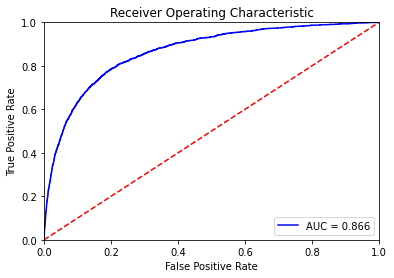

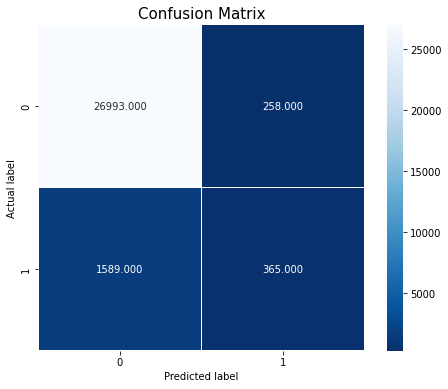

0.8660504115293188

In [18]:
logistic(X_train, y_train, X_valid, y_valid)

**Comment:** WOE has improved both Precison(0.58) and recall(0.19) achieving a good AUC score of 0.866

#Conclusion

In [ ]:
woe_inputs = woe_df.loc[:, woe_df.columns.values[1:]]
woe_target = woe_df.loc[:, woe_df.columns.values[0]].to_frame()

#stratified split
X_train, X_valid, y_train, y_valid = train_test_split(woe_inputs, woe_target,
                                                      test_size = 0.2, random_state = 42, stratify = np.array(df_train_target))
lr = LogisticRegression(max_iter=300, solver = 'liblinear')

#fit logistic regression
lr.fit(X_train, y_train)

#predictions 1 or 0
y_pred = lr.predict(X_valid)

#predictions in probalities
y_pred_proba = lr.predict_proba(X_valid)
y_pred_proba = y_pred_proba[: ][: , 1]

In [ ]:
# y_test_temp = pd.DataFrame(y_valid)
# X_valid = pd.DataFrame(X_valid)
y_valid.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_valid, pd.DataFrame(y_pred_proba)], axis = 1)
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_valid.index
y_test_proba

,y_test_class_actual,y_hat_test_proba
146670,0,0.030736
312,0,0.016005
73805,0,0.073896
136245,0,0.224293
57394,0,0.009620
...,...,...
9934,0,0.012419
64143,0,0.016479
44590,0,0.013707
2170,1,0.779367


In [ ]:
factor= 20/np.log(2)
offset = 600-factor*np.log(50)
scorecard=X_valid.copy()
scorecard['logit'] = np.log(((y_pred_proba)/(1-y_pred_proba)))
scorecard['score'] = offset - factor*scorecard['logit'] 
scorecard['proba'] = y_pred_proba
scorecard

,PastDue30-59:11-13-18-10,PastDue30-59:6-7-12,PastDue30-59:5-4,PastDue30-59:3,PastDue30-59:9-8,PastDue30-59:2,PastDue30-59:1,PastDue60-89:11-6-9,PastDue60-89:4-5,PastDue60-89:3-18,PastDue60-89:7-8,PastDue60-89:2,PastDue60-89:1,PastDue90:9-7-17-15-8,PastDue90:4-5,PastDue90:6-10-11,PastDue90:3-18,PastDue90:12-13-14,PastDue90:2,PastDue90:1,NumberOfDependents:>9,NumberOfDependents:6,NumberOfDependents:4,NumberOfDependents:1,NumberOfDependents:2,...,NumberOfOpenCreditLinesAndLoans:19,NumberOfOpenCreditLinesAndLoans:20-24,NumberOfOpenCreditLinesAndLoans:24-26,NumberRealEstateLoansOrLines:0,NumberRealEstateLoansOrLines:1,NumberRealEstateLoansOrLines:2,NumberRealEstateLoansOrLines:3,NumberRealEstateLoansOrLines:4,NumberRealEstateLoansOrLines:5,NumberRealEstateLoansOrLines:6,NumberRealEstateLoansOrLines:7,age:<24,age:24-33,age:33-36,age:36-42,age:42-55,age:55-58,age:58-64,age:64-67,age:67-70,age:70-73,age:73-89,logit,score,proba
146670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-3.451093,586.700376,0.030736
312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-4.118697,605.963345,0.016005
73805,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-2.528334,560.075161,0.073896
136245,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1.240821,522.925406,0.224293
57394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-4.634290,620.840214,0.009620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-4.375996,613.387441,0.012419
64143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-4.089071,605.108517,0.016479
44590,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-4.276046,610.503480,0.013707
2170,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.261979,450.709855,0.779367
